In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys
sys.path.append('..')

import ekg
from ekg.utils.eval_utils import parse_wandb_models
from ekg.audicor_reader import reader
from ekg.audicor_reader import denoise
from ekg.utils.data_utils import BaseDataGenerator

import tempfile
import wandb
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


## Abnormal Detection

### There are three ways to load models

#### 1. Parse models from wandb sweep

In [2]:
models, configs, model_paths, sweep_name = parse_wandb_models(path=['toosyou/ekg-abnormal_detection/e7dyx0xq'], # which is a sweep path
                                                              numbers_models=5, # the best 5 models
                                                              metric='best_val_loss')

/mnt/nas/homes/toosyou/.local/share/virtualenvs/ekg-O1HNDDTX/lib/python3.6/site-packages/wandb/apis/public.py:1117: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(self._attrs["config"])
/mnt/nas/homes/toosyou/.local/share/virtualenvs/ekg-O1HNDDTX/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1030: UserWarning: ekg.models.backbone is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [3]:
models

#### 2. Parse models from wandb runs

In [4]:
models, configs, model_paths, sweep_name = parse_wandb_models(path=['toosyou/ekg-abnormal_detection/v8yxjme4',
                                                                       'toosyou/ekg-abnormal_detection/o2hzukos',
                                                                        'toosyou/ekg-abnormal_detection/2h2n98sf'], # which are run paths
                                                              numbers_models=None, # set to None to treat path as run paths
                                                              metric=None) # ignored

In [5]:
models

#### 3. Check `ekg/utils/eval_utils/parse_wandb_models` for parsing models from .h5 model files
where .h5 model files can be downloaded manually from wandb run page

### Load a new signal for prediction

In [6]:
# reader for .bin files
signal, _ = reader.get_ekg('/home/toosyou/Cardiology/TVGS/交大-normal/大檢查audicor/NOR001/PP-01_000708.bin',
                          do_bandpass_filter=False) # turn off filter for demonstration 
signal.shape

(10, 10000)

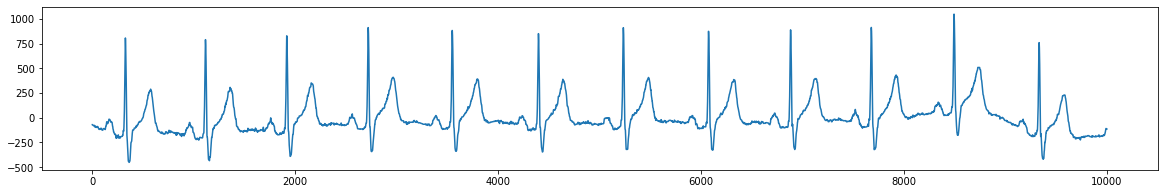

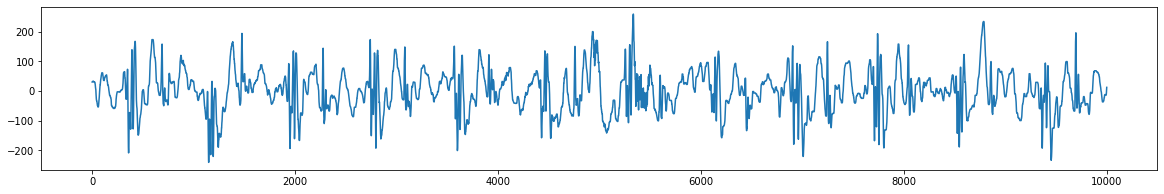

In [7]:
# since the models are for 1ekg + 1hs
signal = signal[[1, -1]]

plt.figure(figsize=(20, 3))
plt.plot(signal[0])
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(signal[1])
plt.show()

### Preprocessing

#### 1. EKG
1. wavelet thresholding
2. baseline wander removal

In [8]:
signal[0] = denoise.ekg_denoise(signal[0:1, :])[0]

/mnt/nas/homes/toosyou/.local/share/virtualenvs/ekg-O1HNDDTX/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 13 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


#### 2. Heart Sound - band pass filters

In [9]:
signal[1] = denoise.heart_sound_denoise(signal[1:2], 
                                            lowcut=30, # Hz
                                            highcut=120, # Hz
                                            fs=1000)[0] # sampling rate in Hz

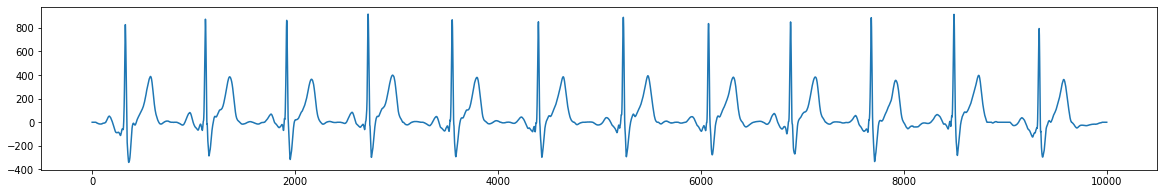

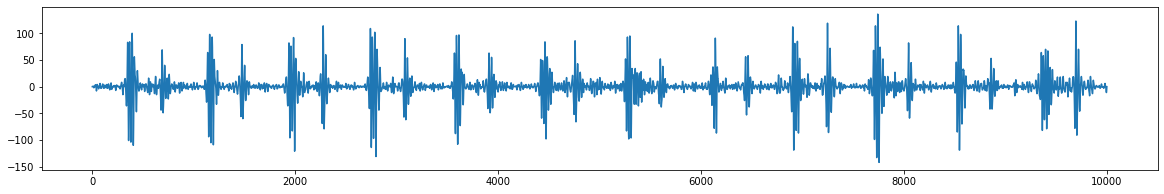

In [10]:
plt.figure(figsize=(20, 3))
plt.plot(signal[0])
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(signal[1])
plt.show()

#### 3. Downsampling so the model can process

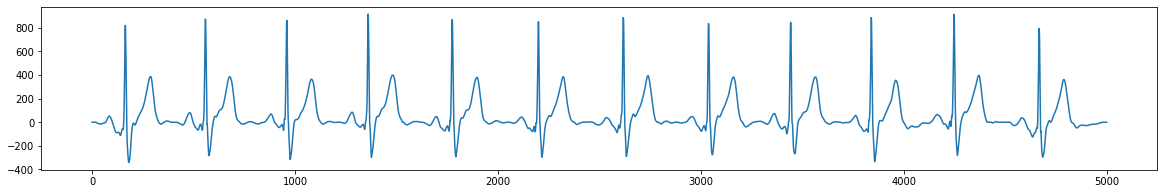

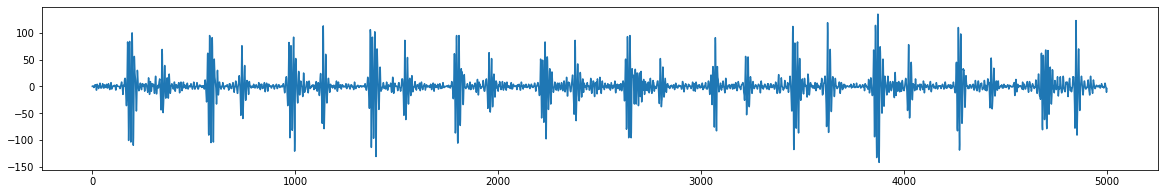

In [11]:
signal = signal[:, ::2]

plt.figure(figsize=(20, 3))
plt.plot(signal[0])
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(signal[1])
plt.show()

#### 4. Normalization
1. First get the mean and std of the original training set by downloading the `means_and_stds.pl` file
2. Use the file to normalize new signals

In [12]:
tmpdir = tempfile.mkdtemp() # get a temp dir

api = wandb.Api()
run = api.run('toosyou/ekg-abnormal_detection/v8yxjme4') # run path
run.file('means_and_stds.pl').download(replace=True, root=tmpdir)

with open(os.path.join(tmpdir, 'means_and_stds.pl'), 'rb') as f:
    means_and_stds = pickle.load(f)
means_and_stds

[[17.571224, -0.0016674922], [113.498276, 136.86205]]

In [13]:
# transpose signal so the normalize function can handdle
signal = signal.T # [n_channels, n_samples] ->  [n_samples, n_channels]
signal = signal[np.newaxis, ...] # [n_samples, n_channels] -> [1, n_samples, n_channels]

signal, _ = BaseDataGenerator.normalize(signal, means_and_stds=means_and_stds)

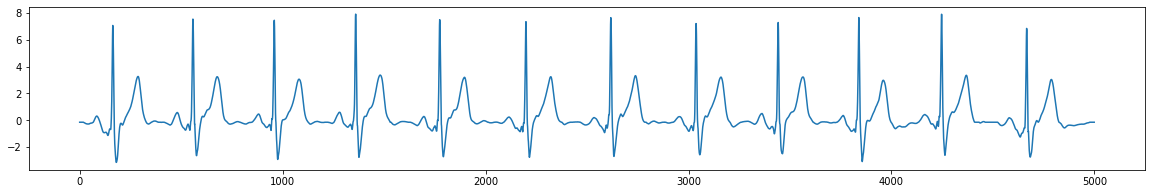

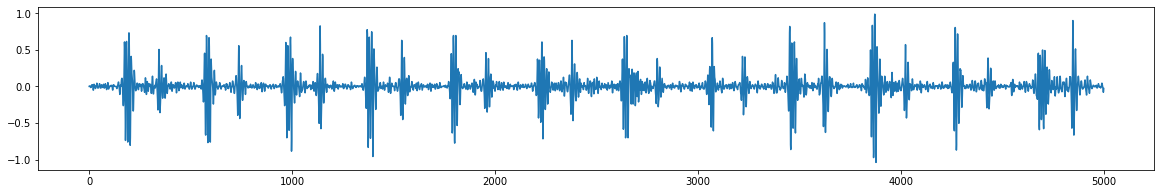

In [14]:
plt.figure(figsize=(20, 3))
plt.plot(signal[0, :, 0])
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(signal[0, :, 1])
plt.show()

### Prediction

where abnormal_score $\in [0, 1]$

In [15]:
abnormal_scores = models[0].predict(signal)[:, 1]
abnormal_scores

array([0.00790077], dtype=float32)

### Ensemble Prediction

In [16]:
abnormal_scores = np.zeros((signal.shape[0], ))
for model in models:
    abnormal_scores += model.predict(signal)[:, 1]
abnormal_scores /= len(models)
abnormal_scores

array([0.01324343])